# [Computational Social Science] Project 4: Unsupervised Learning

**Marwa Abubakr:**

**In Collaboration with Hesham Jarmakani & Mohammed Mohammed**

*Semester:* Fall 2025

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [2]:
!pip install tensorflow 
!pip install keras

119.48s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.6/620.6 MB 21.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 102.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18/18 [tensorflow]8 [tensorflow]]data-server]


174.07s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [3]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

2025-12-17 21:39:32.613520: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-17 21:39:32.651139: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-17 21:39:34.005823: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/srv/conda/lib/python3.11/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_v

In [5]:
# Load nhanes data
nhanes = pd.read_csv('data/nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

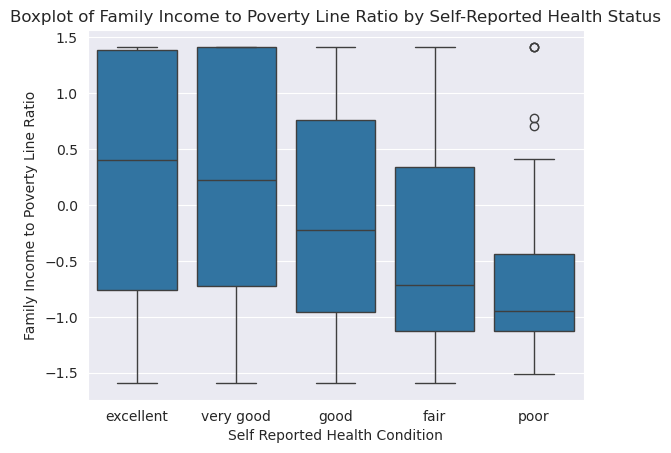

In [6]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

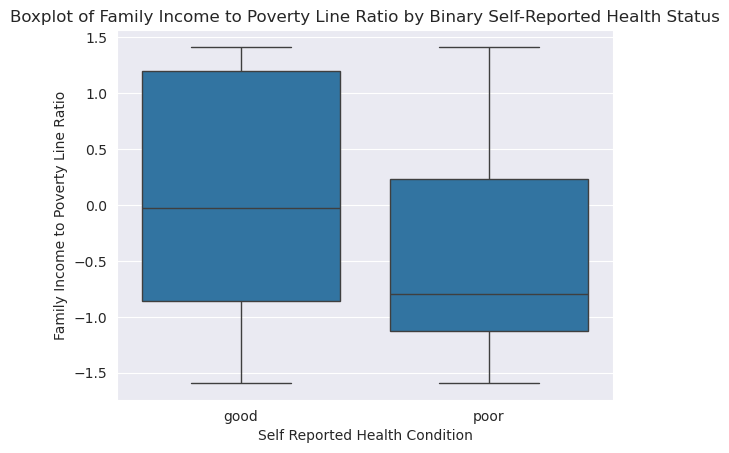

In [7]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income does not appear to map cleanly onto health outcomes. In the figure below, BMI shows no obvious relationship with the family income–poverty ratio, even when observations are colored by self-reported health status. The absence of a clear pattern suggests that income alone is limited in explaining health differences, making clustering a useful next step for identifying meaningful subgroups in the data.

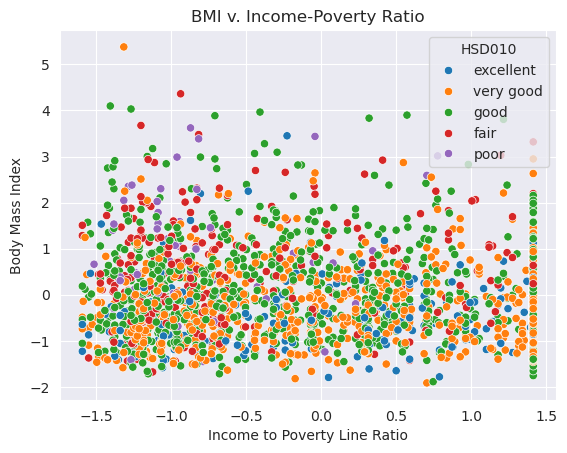

In [8]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Out target variables: 

In [9]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [10]:
# 1. Fit PCA with all components first, once graphed we will see how many components to choose.
pca_10 = PCA(n_components= 10)            
pca_10.fit(nhanes_scaled)

explained_var = pca_10.explained_variance_ratio_
cum_explained_var = explained_var.cumsum()

### Barplot of Components

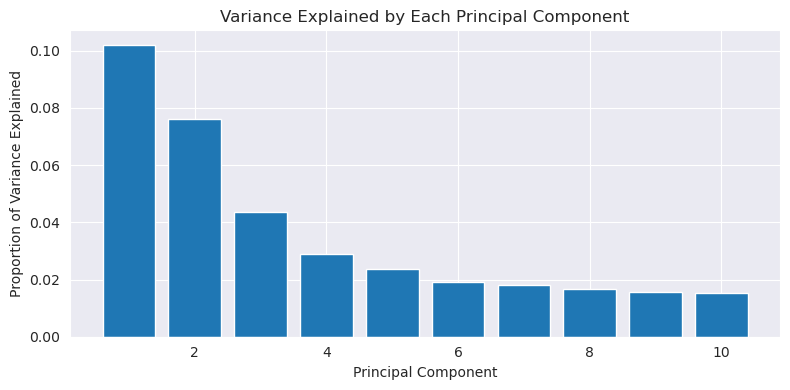

In [11]:
# 2. barplot of variance explained by each component
plt.figure(figsize=(8,4))
plt.bar(range(1, len(explained_var)+1), explained_var)
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.title("Variance Explained by Each Principal Component")
plt.tight_layout()
plt.show()

### How many components will you use to fit a supervised learning model?

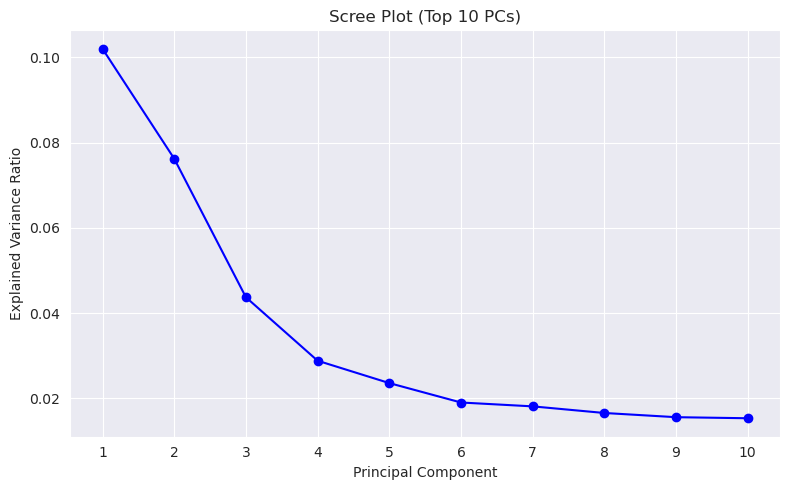

In [12]:
#scree plot for top 10 components to determine how many components to keep 
explained_variance = pca_10.explained_variance_ratio_  # from PCA(n_components=10)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'bo-')
plt.title('Scree Plot (Top 10 PCs)')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance) + 1))
plt.tight_layout()
plt.show()


The scree plot suggests diminishing returns after the third principal component. Explained variance drops sharply beyond this point, so we focused on the first three components to keep the analysis straightforward.

### 2D Scatterplot of the first two components

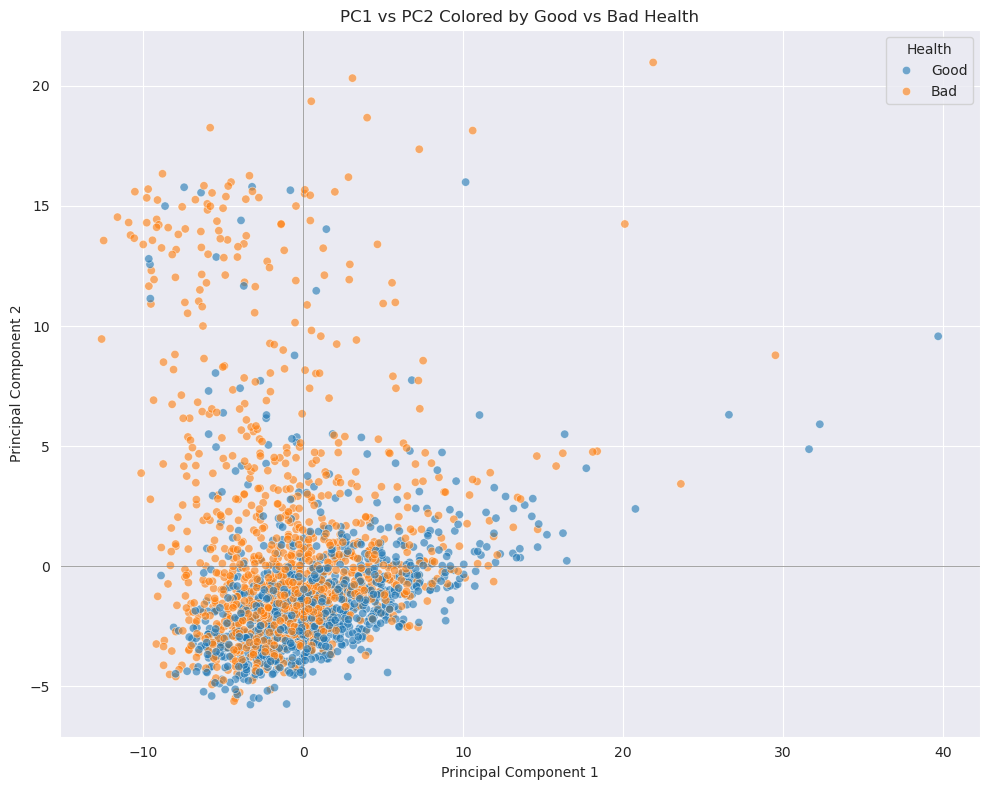

In [13]:
#2d scatter plot of the first two components, colored by good vs bad health 
# 1. PCA on predictors 
pca_2 = PCA(n_components=2)
nhanes_pca_2 = pca_2.fit_transform(nhanes_scaled)

# 2. Make a binary outcome from HSD010 (example rule: 1–2 = good, 3–5 = bad)
health_bin = hsd010.replace({1: "Good", 2: "Good", 3: "Bad", 4: "Bad", 5: "Bad"})

# 3. Put PCs + outcome in a DataFrame
pc_df = pd.DataFrame({
    "PC1": nhanes_pca_2[:, 0],
    "PC2": nhanes_pca_2[:, 1],
    "Health": health_bin
})

# 4. Plot PC1 vs PC2, colored by good vs bad health
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pc_df, x="PC1", y="PC2", hue="Health", alpha=0.6)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PC1 vs PC2 Colored by Good vs Bad Health")
plt.axhline(0, color="grey", linewidth=0.5)
plt.axvline(0, color="grey", linewidth=0.5)
plt.tight_layout()
plt.show()


The scatterplot of the first two principal components shows that these components capture meaningful structure in the predictors, but observations labeled “Good” and “Bad” health remain largely intermixed. This indicates that PCA alone does not produce a clear separation by health status. There is a modest concentration of “Bad” health observations in the upper-left region of the plot, suggesting that certain predictor combinations are associated with poorer self-reported health, though substantial overlap remains.

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

We chose k-means clustering, which groups observations into k clusters by minimizing within-cluster variation. The algorithm iteratively assigns points to the nearest centroid and updates centroids as cluster means, allowing us to identify structure in the data without relying on labeled outcomes.

### Cluster nhanes

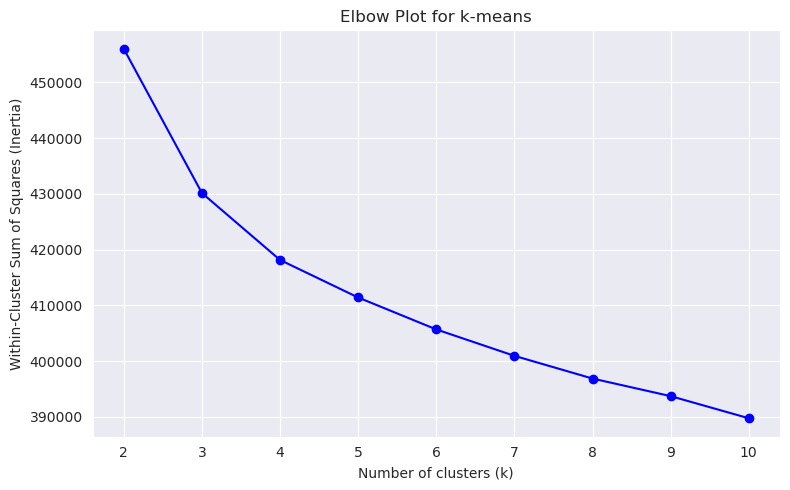

In [14]:
## K means clustering on nhanes data 

X = nhanes_scaled  

# --- Elbow method to choose k ---
inertias = []
k_values = range(2, 11)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.title('Elbow Plot for k-means')
plt.xticks(k_values)
plt.tight_layout()
plt.show()


In [15]:
k_opt = 4  # set to your chosen k based on the elbow plot

kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

nhanes_clusters = nhanes_scaled.copy()
nhanes_clusters['cluster'] = clusters


### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

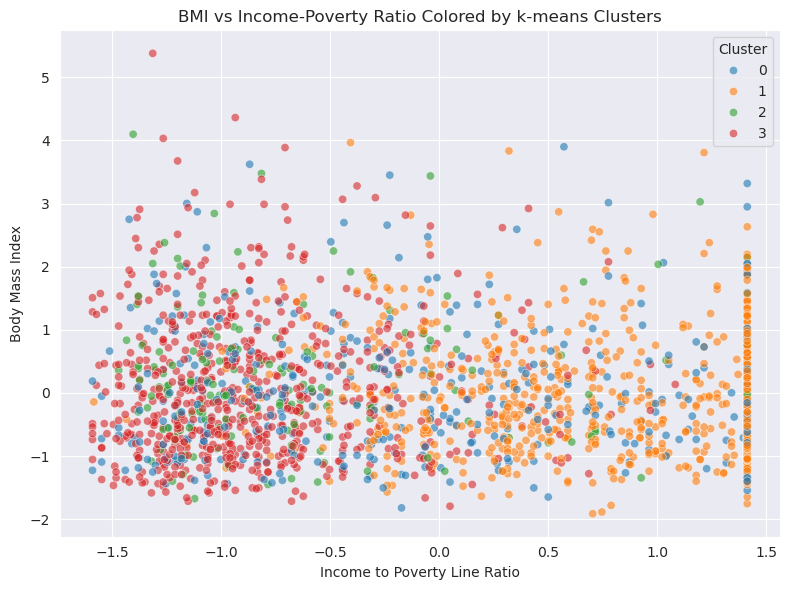

In [16]:

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=nhanes_clusters,
    x='INDFMPIR',
    y='BMXBMI',
    hue='cluster',
    palette='tab10',
    alpha=0.6
)
plt.xlabel('Income to Poverty Line Ratio')
plt.ylabel('Body Mass Index')
plt.title('BMI vs Income-Poverty Ratio Colored by k-means Clusters')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()


The clusters separate primarily along the income–poverty ratio axis. BMI shows substantial overlap across clusters and varies widely within them, suggesting that income is more closely aligned with the k-means structure than BMI.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

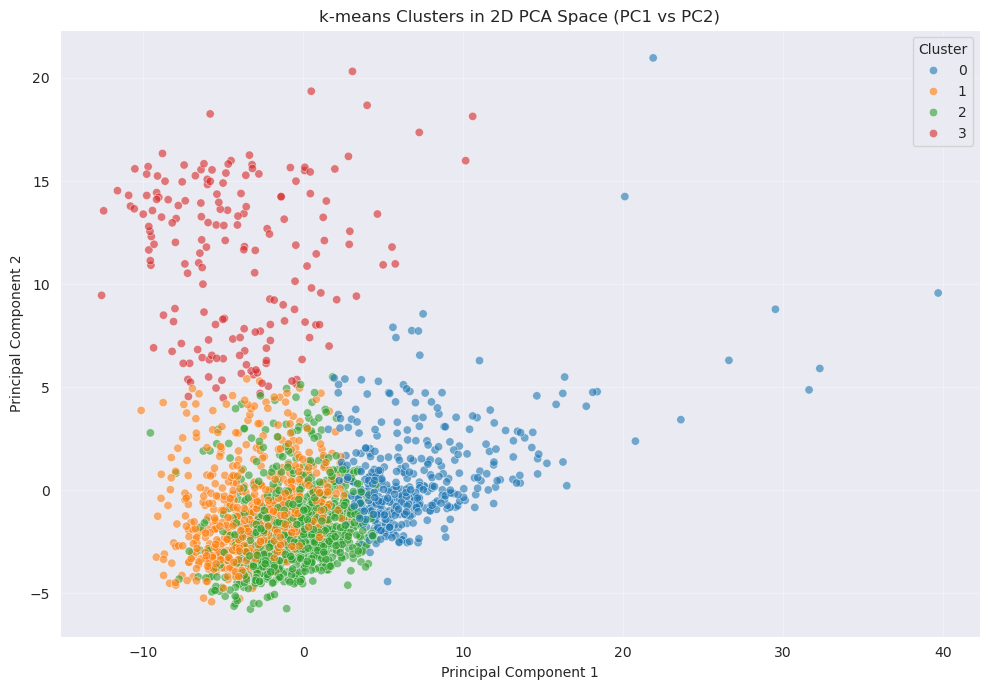

In [17]:
# kmeans on PCA scores instead of original features
# 1. PCA with 3 components
pca = PCA(n_components=3, random_state=42)
X_pca3 = pca.fit_transform(nhanes_scaled)   # shape: (n_samples, 3)

# 2. k-means on the 2-D PCA scores K= 4
k_opt = 4
kmeans_pca3 = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
clusters_pca3 = kmeans_pca3.fit_predict(X_pca3)

# 3. DataFrame for plotting first two PCs + cluster labels
pca_cluster_df = pd.DataFrame({
    'PC1': X_pca3[:, 0],
    'PC2': X_pca3[:, 1],
    'cluster': clusters_pca3
})

# 4. Plot clusters on the 2D PCA scatterplot (PC1 vs PC2)
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=pca_cluster_df,
    x='PC1', y='PC2',
    hue='cluster',
    palette='tab10',
    alpha=0.6
)
plt.title('k-means Clusters in 2D PCA Space (PC1 vs PC2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


When k-means is applied to the PCA components, each color represents a cluster of respondents with similar predictor profiles. Clustering in the reduced PCA space highlights clearer subgroup structure and makes the patterns in the data easier to visualize and interpret.

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features 3.5 

In [18]:
# partition data
# -----------
y = hsd010.replace({1:0, 2:1, 3:2, 4:3, 5:4})   # convert to 0–4 for NN
X = nhanes_scaled                                 # features only (already numeric)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [19]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 5
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

In [20]:
# create neural network model
# -----------
model = Sequential()

model.add(Dense(64, input_dim= X_train.shape[1], kernel_initializer= 'he_uniform', activation= 'relu'))

model.add(Dense(32, kernel_initializer= 'he_uniform', activation= 'relu'))

model.add(Dense(5, activation='softmax'))

## Add any additional layers you wish here

model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

/srv/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-12-17 21:42:47.404327: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3527 - loss: 1.5967 - val_accuracy: 0.3857 - val_loss: 1.3732
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4767 - loss: 1.2184 - val_accuracy: 0.4457 - val_loss: 1.3097
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5497 - loss: 1.0751 - val_accuracy: 0.4438 - val_loss: 1.2822
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6008 - loss: 0.9714 - val_accuracy: 0.4574 - val_loss: 1.2690
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6531 - loss: 0.8815 - val_accuracy: 0.4729 - val_loss: 1.2627
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7067 - loss: 0.7953 - val_accuracy: 0.4593 - val_loss: 1.2721
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7422 - loss: 0.7192 - val_accuracy: 0.4709 - val_loss: 1.2880
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7771 - loss: 0.6438 - val_accuracy: 0.4477 - val_loss

### Neural Network on Principal Components

In [21]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(nhanes_scaled)

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.25, random_state=10
)

num_classes = 5
y_train = to_categorical(y_train, num_classes)
y_test  = to_categorical(y_test,  num_classes)

model = Sequential()

model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20, batch_size=32, verbose=1
)

Epoch 1/20


/srv/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2339 - loss: 1.8342 - val_accuracy: 0.3508 - val_loss: 1.5046
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4037 - loss: 1.4358 - val_accuracy: 0.4302 - val_loss: 1.3732
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4380 - loss: 1.3571 - val_accuracy: 0.4399 - val_loss: 1.3335
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4561 - loss: 1.3227 - val_accuracy: 0.4496 - val_loss: 1.3080
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4587 - loss: 1.2964 - val_accuracy: 0.4477 - val_loss: 1.2927
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4561 - loss: 1.2777 - val_accuracy: 0.4516 - val_loss: 1.2812
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4658 - loss: 1.2626 - val_accuracy: 0.4477 - val_loss: 1.2764
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4561 - loss: 1.2535 - val_accuracy: 0.4419 - val_loss: 1.2722
Ep

### Neural Network on Principal Components + Cluster Membership

In [22]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(nhanes_scaled)

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_pca)  

cluster_encoded = pd.get_dummies(clusters, prefix='cluster').values
X_nn = np.hstack([X_pca, cluster_encoded])

y = hsd010.replace({1:0, 2:1, 3:2, 4:3, 5:4})  
y_train, y_test, X_train, X_test = train_test_split(y, X_nn, test_size=0.25, random_state=10)

y_train = to_categorical(y_train, num_classes=5)
y_test  = to_categorical(y_test, num_classes=5)

model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

Epoch 1/20


/srv/conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3508 - loss: 1.5658 - val_accuracy: 0.4283 - val_loss: 1.4079
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4360 - loss: 1.3614 - val_accuracy: 0.4593 - val_loss: 1.3266
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4438 - loss: 1.3004 - val_accuracy: 0.4438 - val_loss: 1.2924
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4696 - loss: 1.2691 - val_accuracy: 0.4477 - val_loss: 1.2744
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4671 - loss: 1.2527 - val_accuracy: 0.4535 - val_loss: 1.2597
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4696 - loss: 1.2404 - val_accuracy: 0.4399 - val_loss: 1.2552
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4658 - loss: 1.2309 - val_accuracy: 0.4457 - val_loss: 1.2486
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4729 - loss: 1.2250 - val_accuracy: 0.4399 - val_loss: 1.2490
Ep

After using PCA (5 components) and adding 4 cluster dummy variables from K means, the neural network achieves approximately 47% training accuracy and 44% validation accuracy. The close train & validation performance suggests that our neural network has limited overfitting, but the overall accuracy is moderate. This suggest that the unsupervised features capture some signal but do not fuly explain the variation in the outcome.  

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA and clustering serve different purposes. PCA is primarily a dimensionality-reduction technique that transforms the original variables into a smaller set of components while preserving as much overall variation in the data as possible. These principal components are linear combinations of the original features and are ordered by how much variance they explain, allowing the data to be represented in a lower-dimensional coordinate system.

Clustering, by contrast, focuses on grouping observations rather than transforming features. It partitions the data into clusters such that observations within the same cluster are more similar to one another than to those in other clusters, typically by minimizing within-cluster distance and maximizing separation across clusters. In our analysis, PCA projected each observation into a two-dimensional space, while k-means clustering then assigned each observation to one of four clusters based on similarity.

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

I did not observe a meaningful performance improvement from adding cluster indicators to the PCA features, with training and validation accuracy remaining around 45–47%. This likely reflects the fact that the PCA components already captured most of the structure present in the data, including patterns that k-means would identify. As a result, the cluster indicators added little new information. It is also possible that the clusters are only weakly related to the outcome, which would further limit their contribution to predictive performance.

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques are useful because they impose structure on large datasets before any prediction task begins. Methods like PCA reduce high-dimensional, correlated inputs into a smaller set of features that retain the most relevant variation, which can make supervised models more efficient and less prone to overfitting. Clustering can reveal meaningful heterogeneity by identifying groups of observations that behave differently, allowing supervised models to account for these differences through additional features or group-specific patterns. Unsupervised tools also play a role in data triage at scale, such as flagging outliers or guiding which observations are most informative to label when labeling is expensive. Together, these approaches help turn messy, high-volume data into cleaner and more informative inputs for supervised learning.